In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from data.loadv2 import get_data, subsample
from data.utils import custom_cutout
from model.metrics import psnr, ssim
from model.losses import *

## Choose Devices

In [2]:
gpu_id = 6
num_cores = 4

In [3]:
torch.cuda.set_device(gpu_id)

# Model

## Initialization

In [4]:
nb_name = 'pssr-toddler-greyscale-poiss'
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/poisson/'
hr_path = f'EM/training/trainsets/hr_greyscale/'
model_path = data_pth/f'EM/models/feat_loss/'

In [5]:
# loading the 1st round of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)
db = subsample(db, seed=49)
db.c = 3

In [6]:
arch = models.resnet34
wd = 1e-3
superres_metrics = [F.mse_loss, psnr, ssim]
learn = unet_learner(db, arch, wd=wd, 
                         loss_func=F.mse_loss,
                         metrics=superres_metrics, 
                         blur=False, 
                         norm_type=NormType.Weight, 
                         model_dir=model_path)
gc.collect()

0

In [7]:
learn = learn.load(f'emsynth_005_unet.5')

In [8]:
# loading the 1st round of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)
db = subsample(db, seed=49)

In [9]:
learn.data = db

In [10]:
learn.model_dir = model_path
print(learn.model_dir)

/home/alaa/Dropbox/BPHO Staff/USF/EM/models/feat_loss


In [11]:
# grab weights from a single channel
kernel_weights = learn.model[0][0].weight[:, 1, :, :].unsqueeze(1)
print(kernel_weights.shape)
# change first layer of resnet to single-channel
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# stick the weights you grabbed earlier into your new first layer
learn.model[0][0].weight = torch.nn.Parameter(data=kernel_weights, requires_grad=True)
print(learn.model[0][0].weight.shape)
# change Merge layers to single-channel input images
learn.model[0][0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
learn.model[10][0][0] = nn.Conv2d(97, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[10][1][0] = nn.Conv2d(97, 97, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
learn.model[11][0] = nn.Conv2d(97, 1, kernel_size=(1, 1), stride=(1, 1))
learn.model.cuda();

torch.Size([64, 1, 7, 7])
torch.Size([64, 1, 7, 7])


## Exporting to pkl

In [14]:
model_pth = '/home/alaa/Dropbox/BPHO Staff/USF/EM/models/baselines'
# nb_name = 'featureloss-adult-pretrained'
expt_num = '3b'
learn.export(f'{nb_name}.{expt_num}.pkl')

In [15]:
learn = load_learner(path=model_pth ,file=f'{nb_name}.{expt_num}.pkl')

## Load Model (optional)

In [48]:
# learn.model_dir = model_pth
# learn = learn.load(f'emsynth_005_unet.5')
# learn = learn.load(f'{nb_name}.3a')

In [12]:
learn.loss_func

<function torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='mean')>

## Training

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


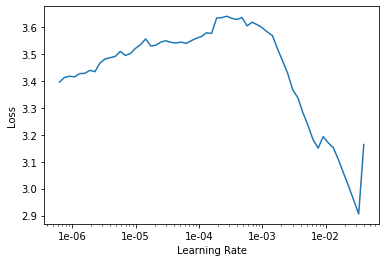

In [14]:
learn.recorder.plot()

### 1a

In [15]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1a', with_opt=False)

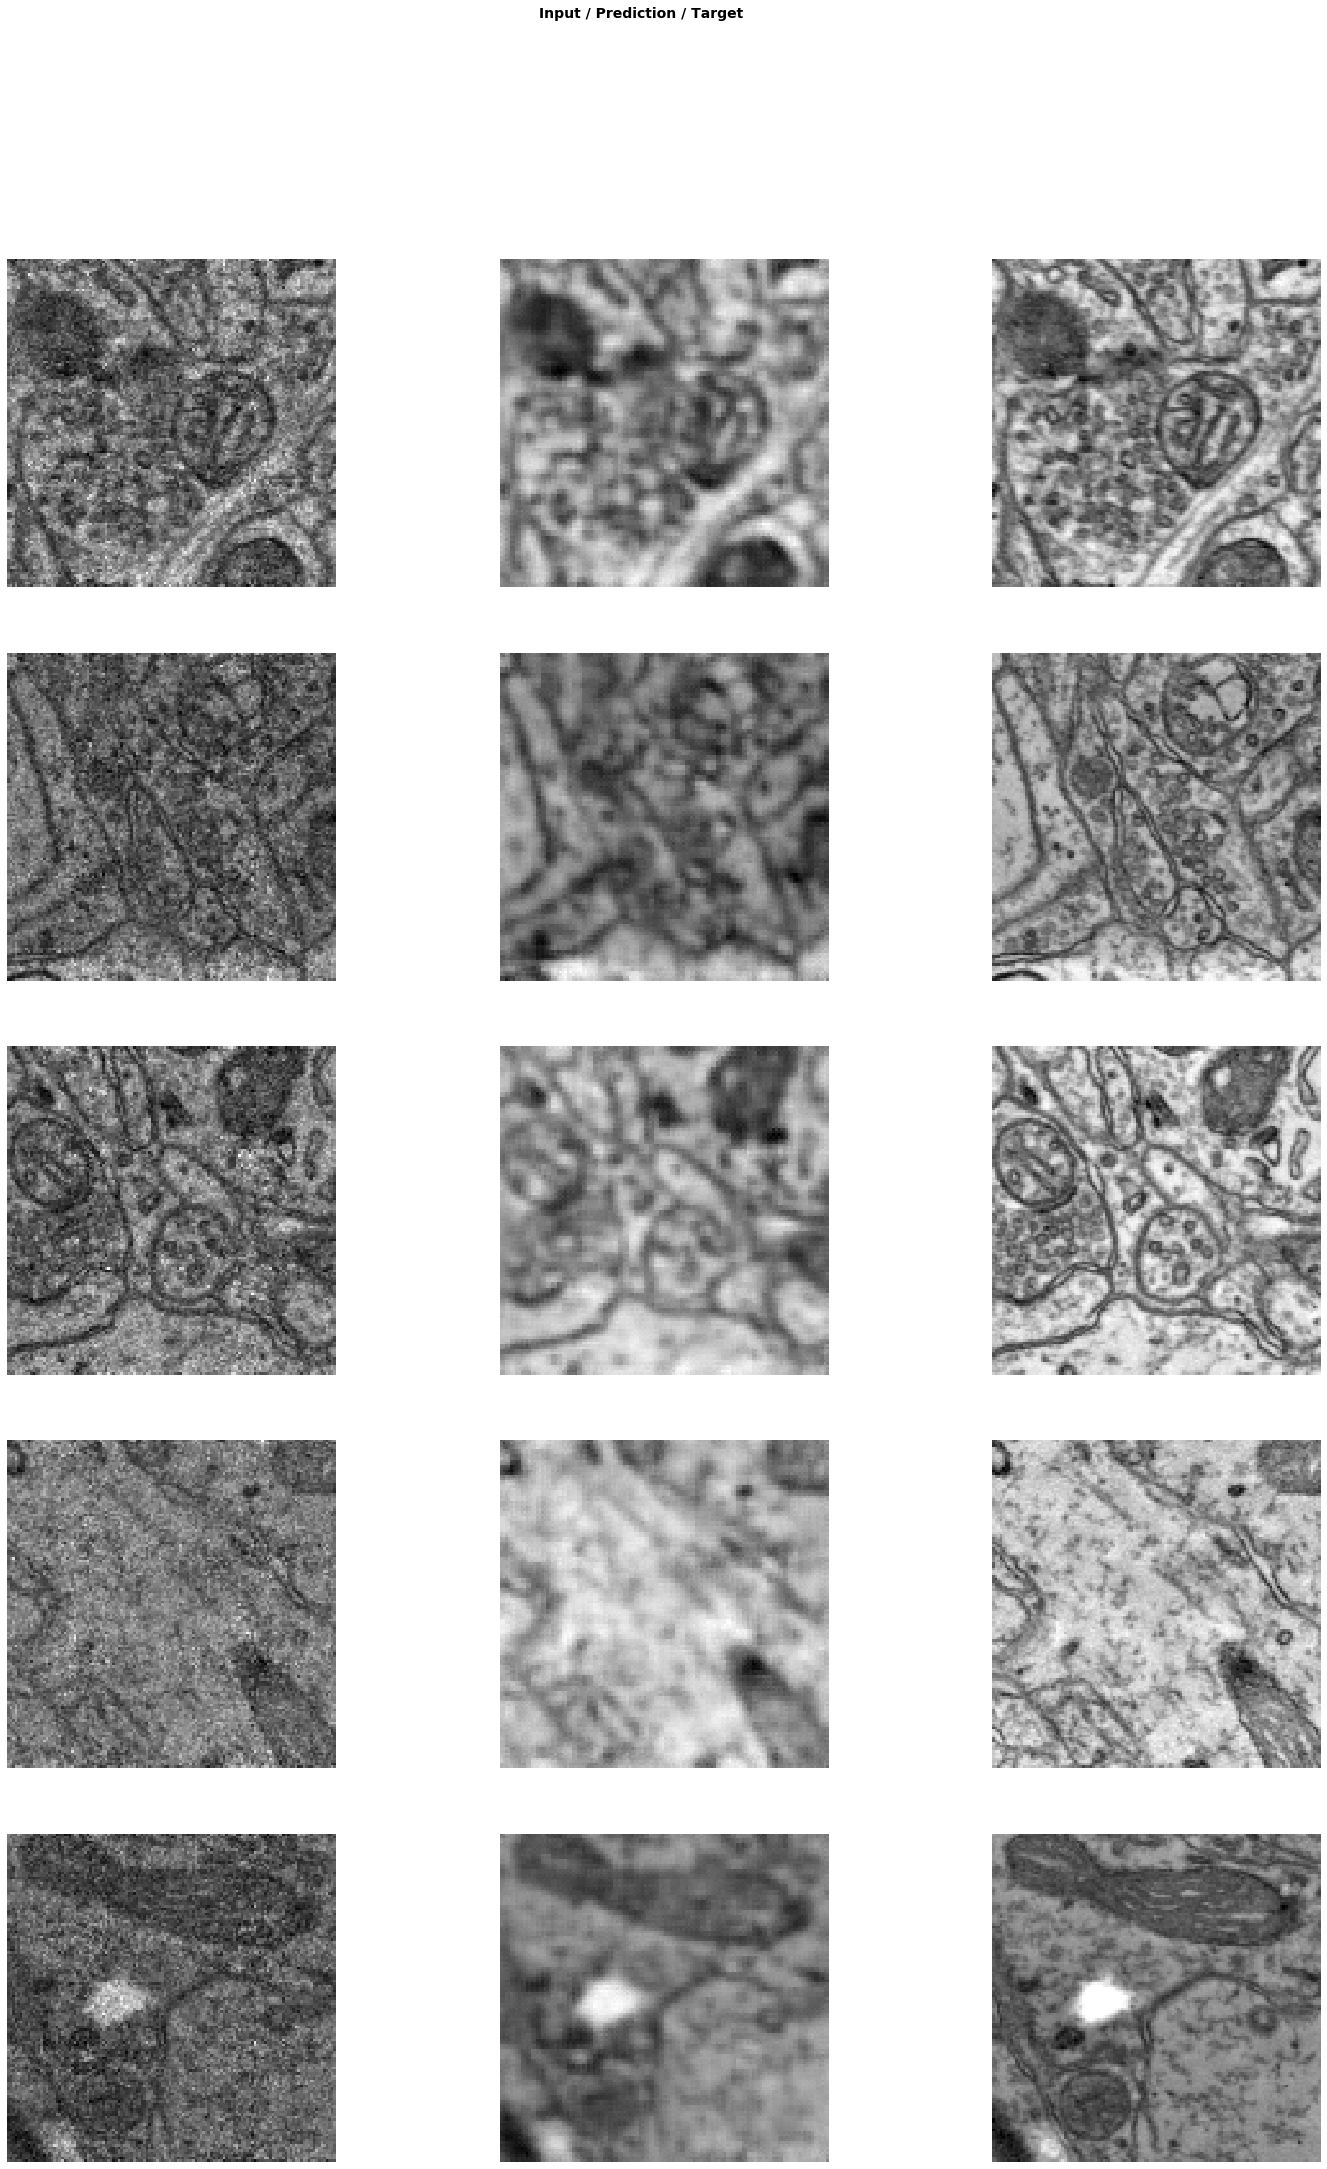

In [16]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)

### 1b

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


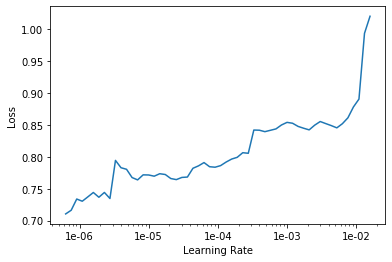

In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [18]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.1b', with_opt=False)

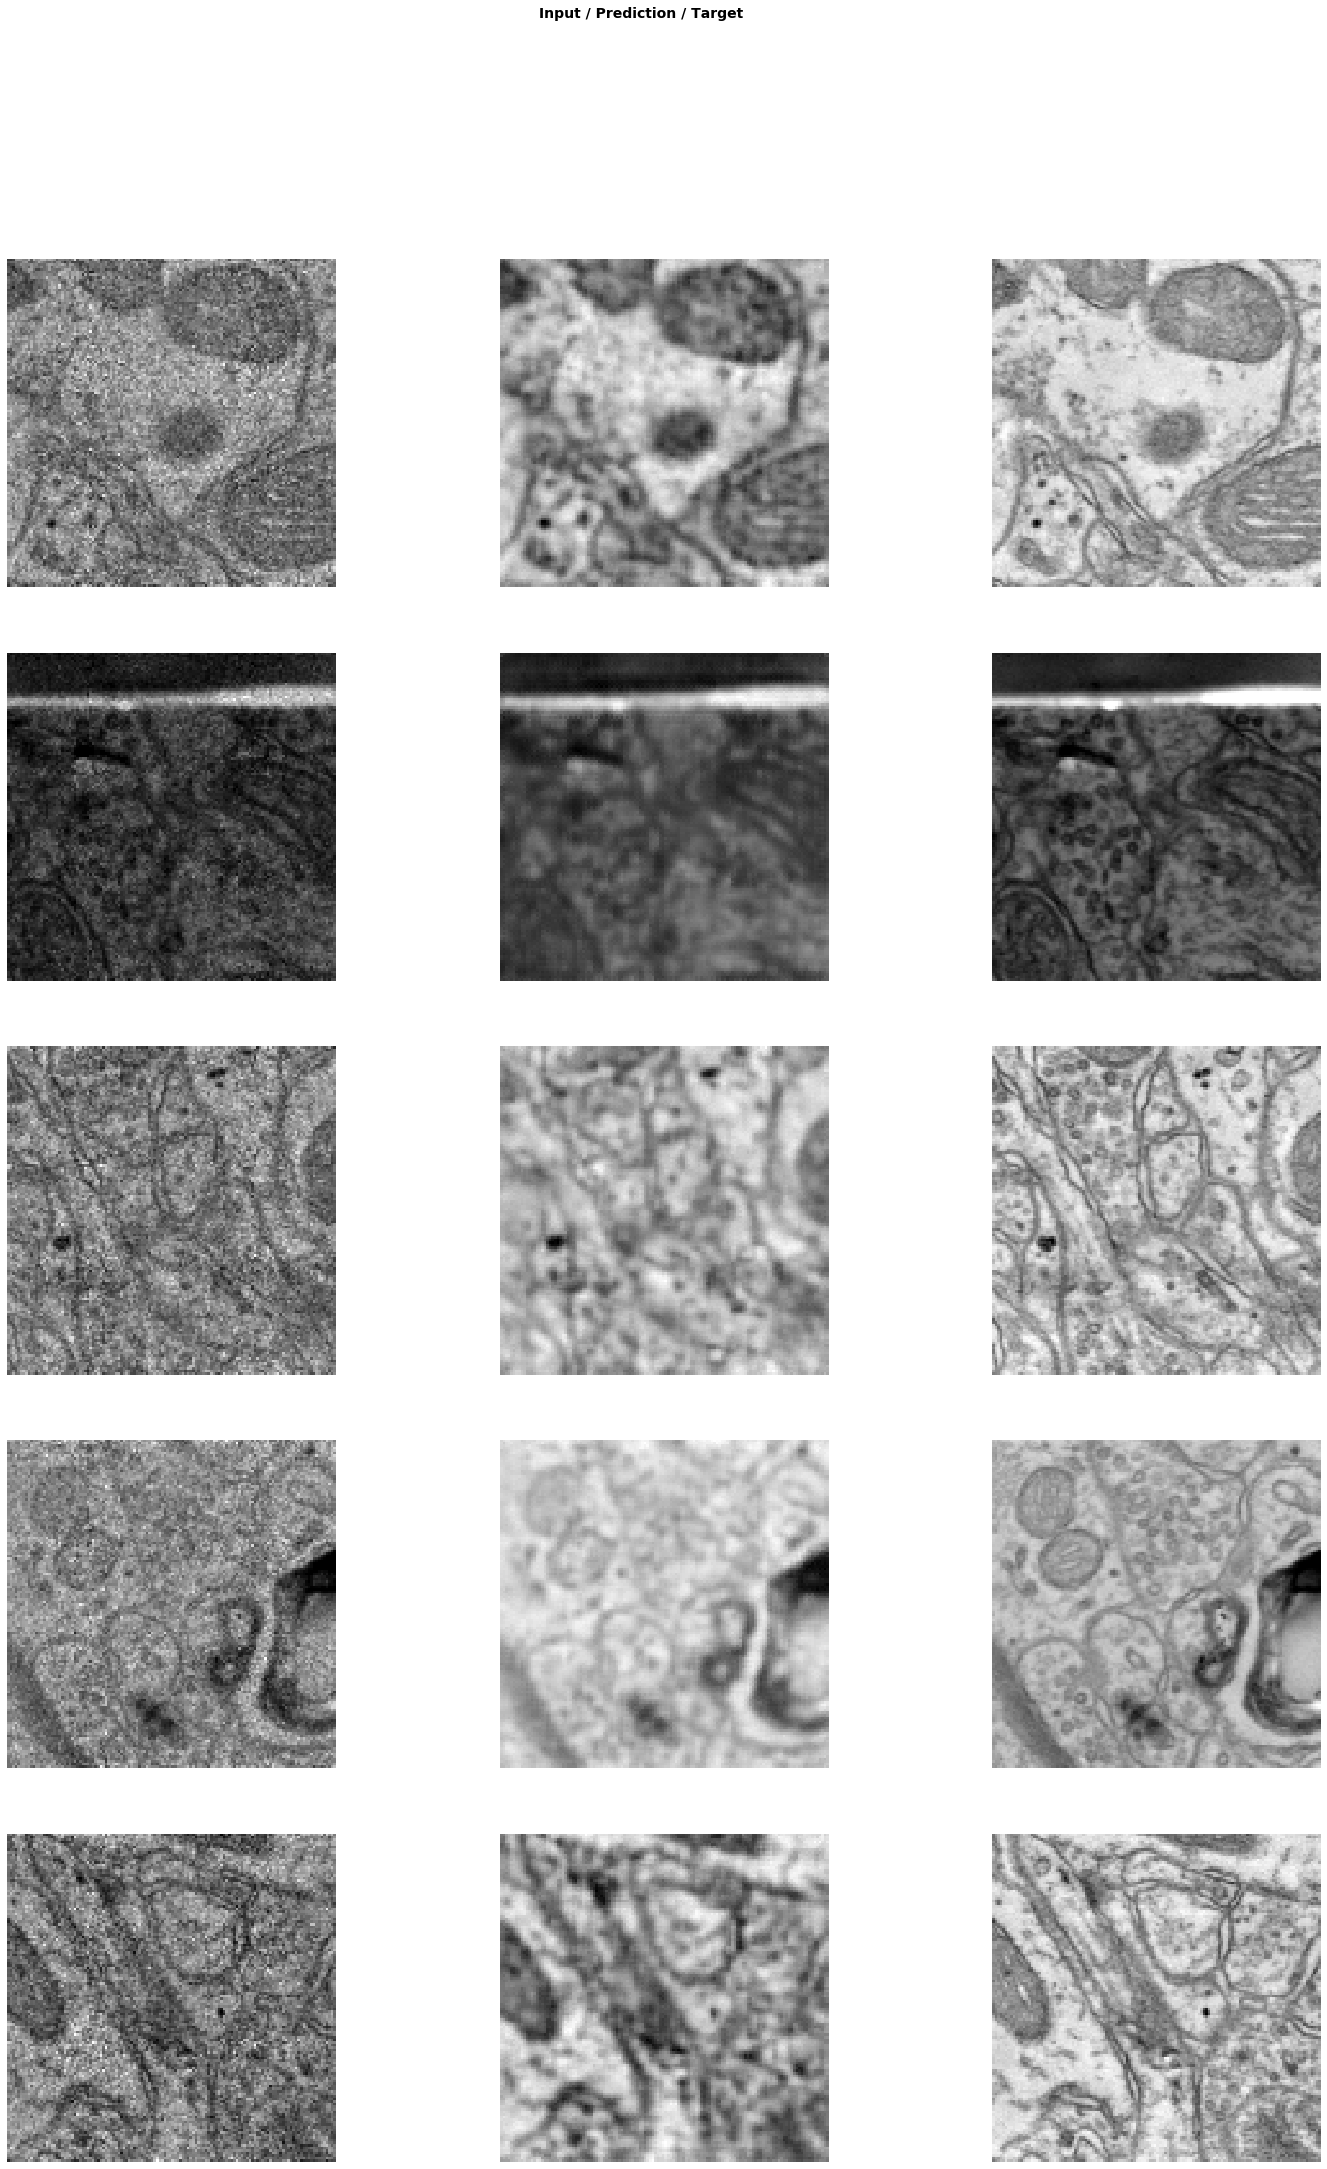

In [19]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)

## 2a

In [20]:
# 2nd round of data
bs_2 = 32
size_2 = 256
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_2, in_sz=size_2, out_sz=size_2, max_zoom=3)
db = subsample(db, seed=6054)

In [21]:
gc.collect()

84

In [22]:
learn.data = db
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


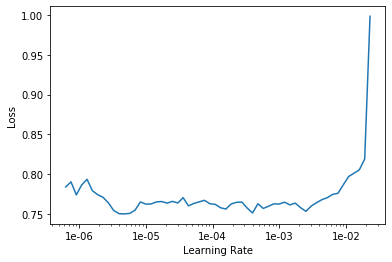

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2a', with_opt=False)

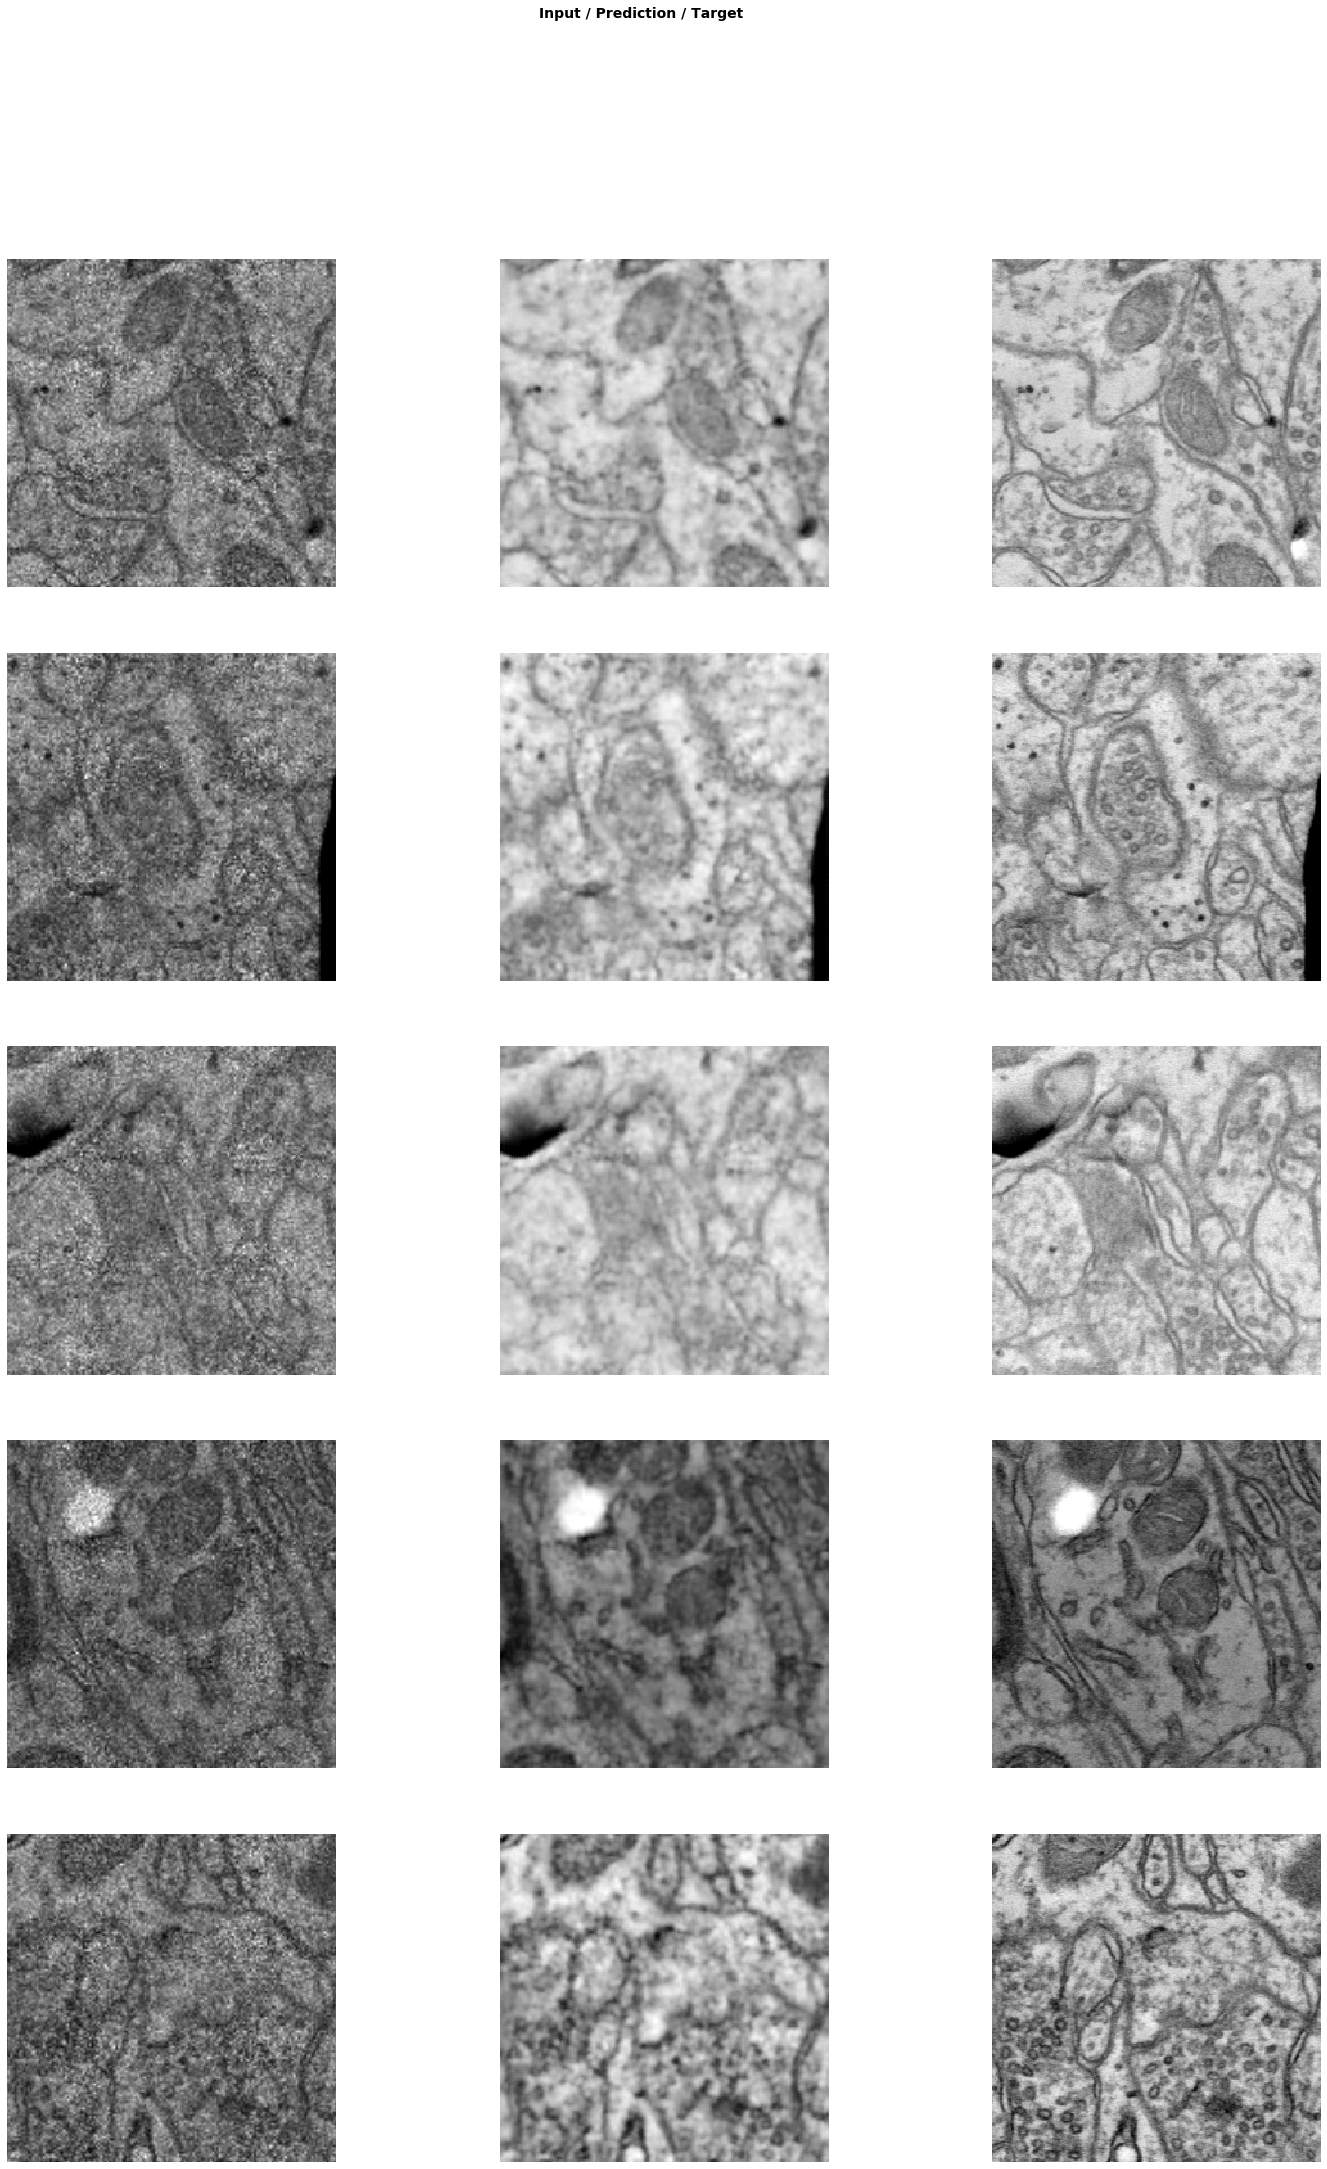

In [25]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)

## 2b

In [26]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


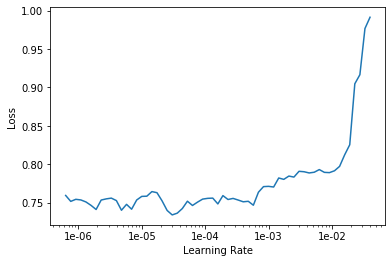

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
lr = slice(1e-5, 1e-3)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.2b', with_opt=False)

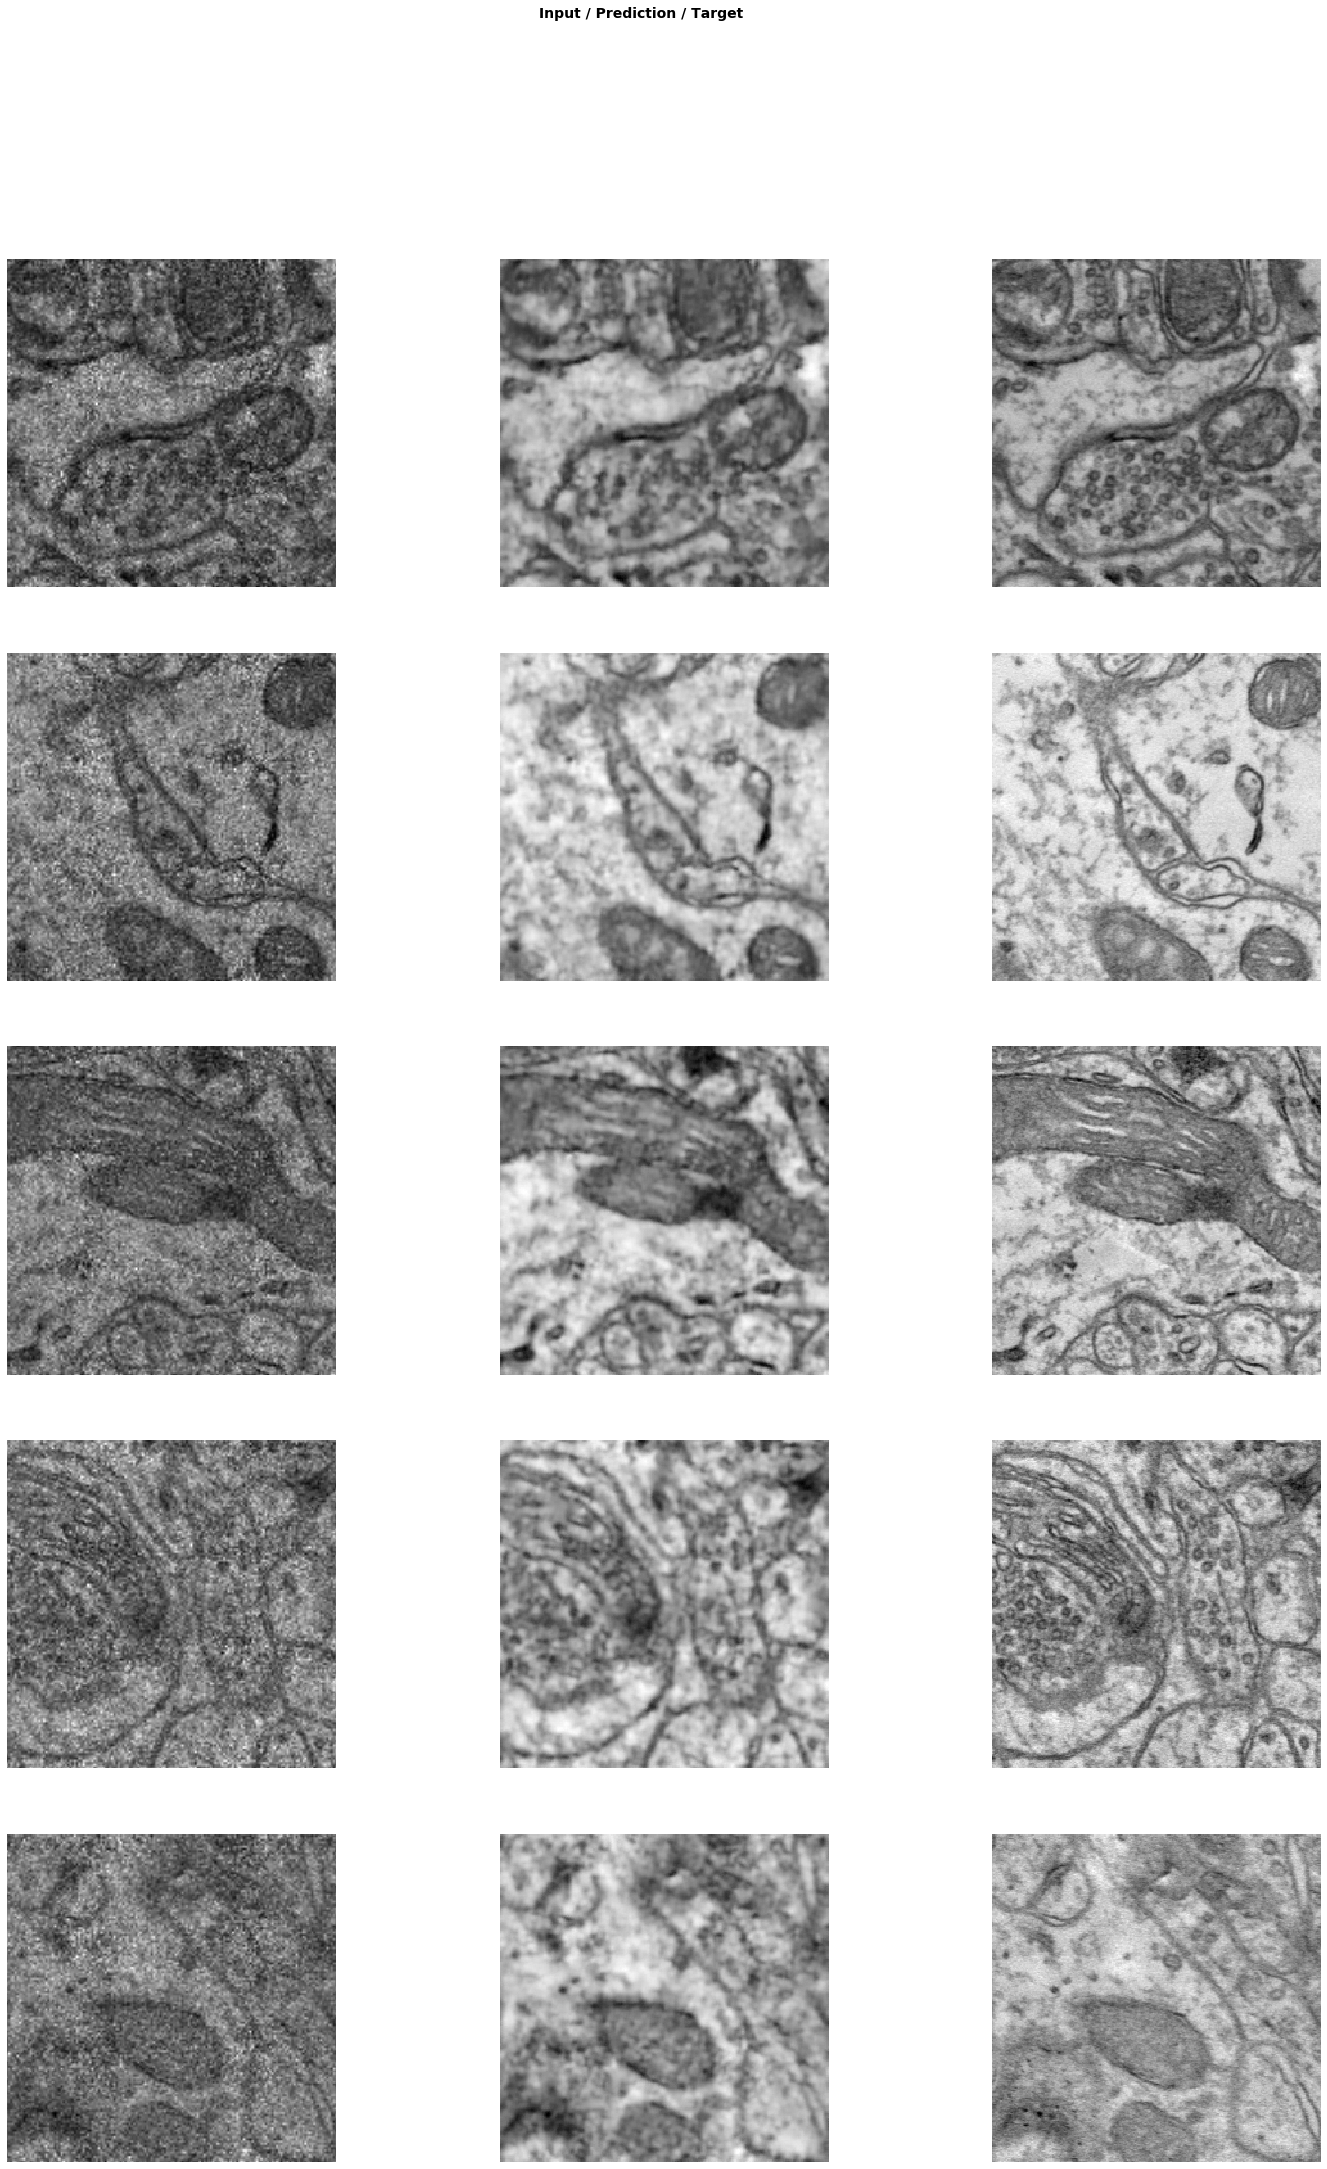

In [29]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)

## 3a

In [30]:
# 3rd round of data
bs_3 = 8
size_3 = 512
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_3, in_sz=size_3, out_sz=size_3, max_zoom=2.)
db = subsample(db, seed=2020)

In [31]:
learn.data = db

In [32]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


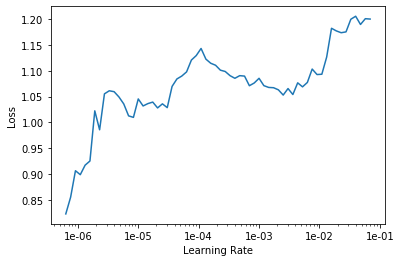

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr = 1e-3
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3a', with_opt=False)

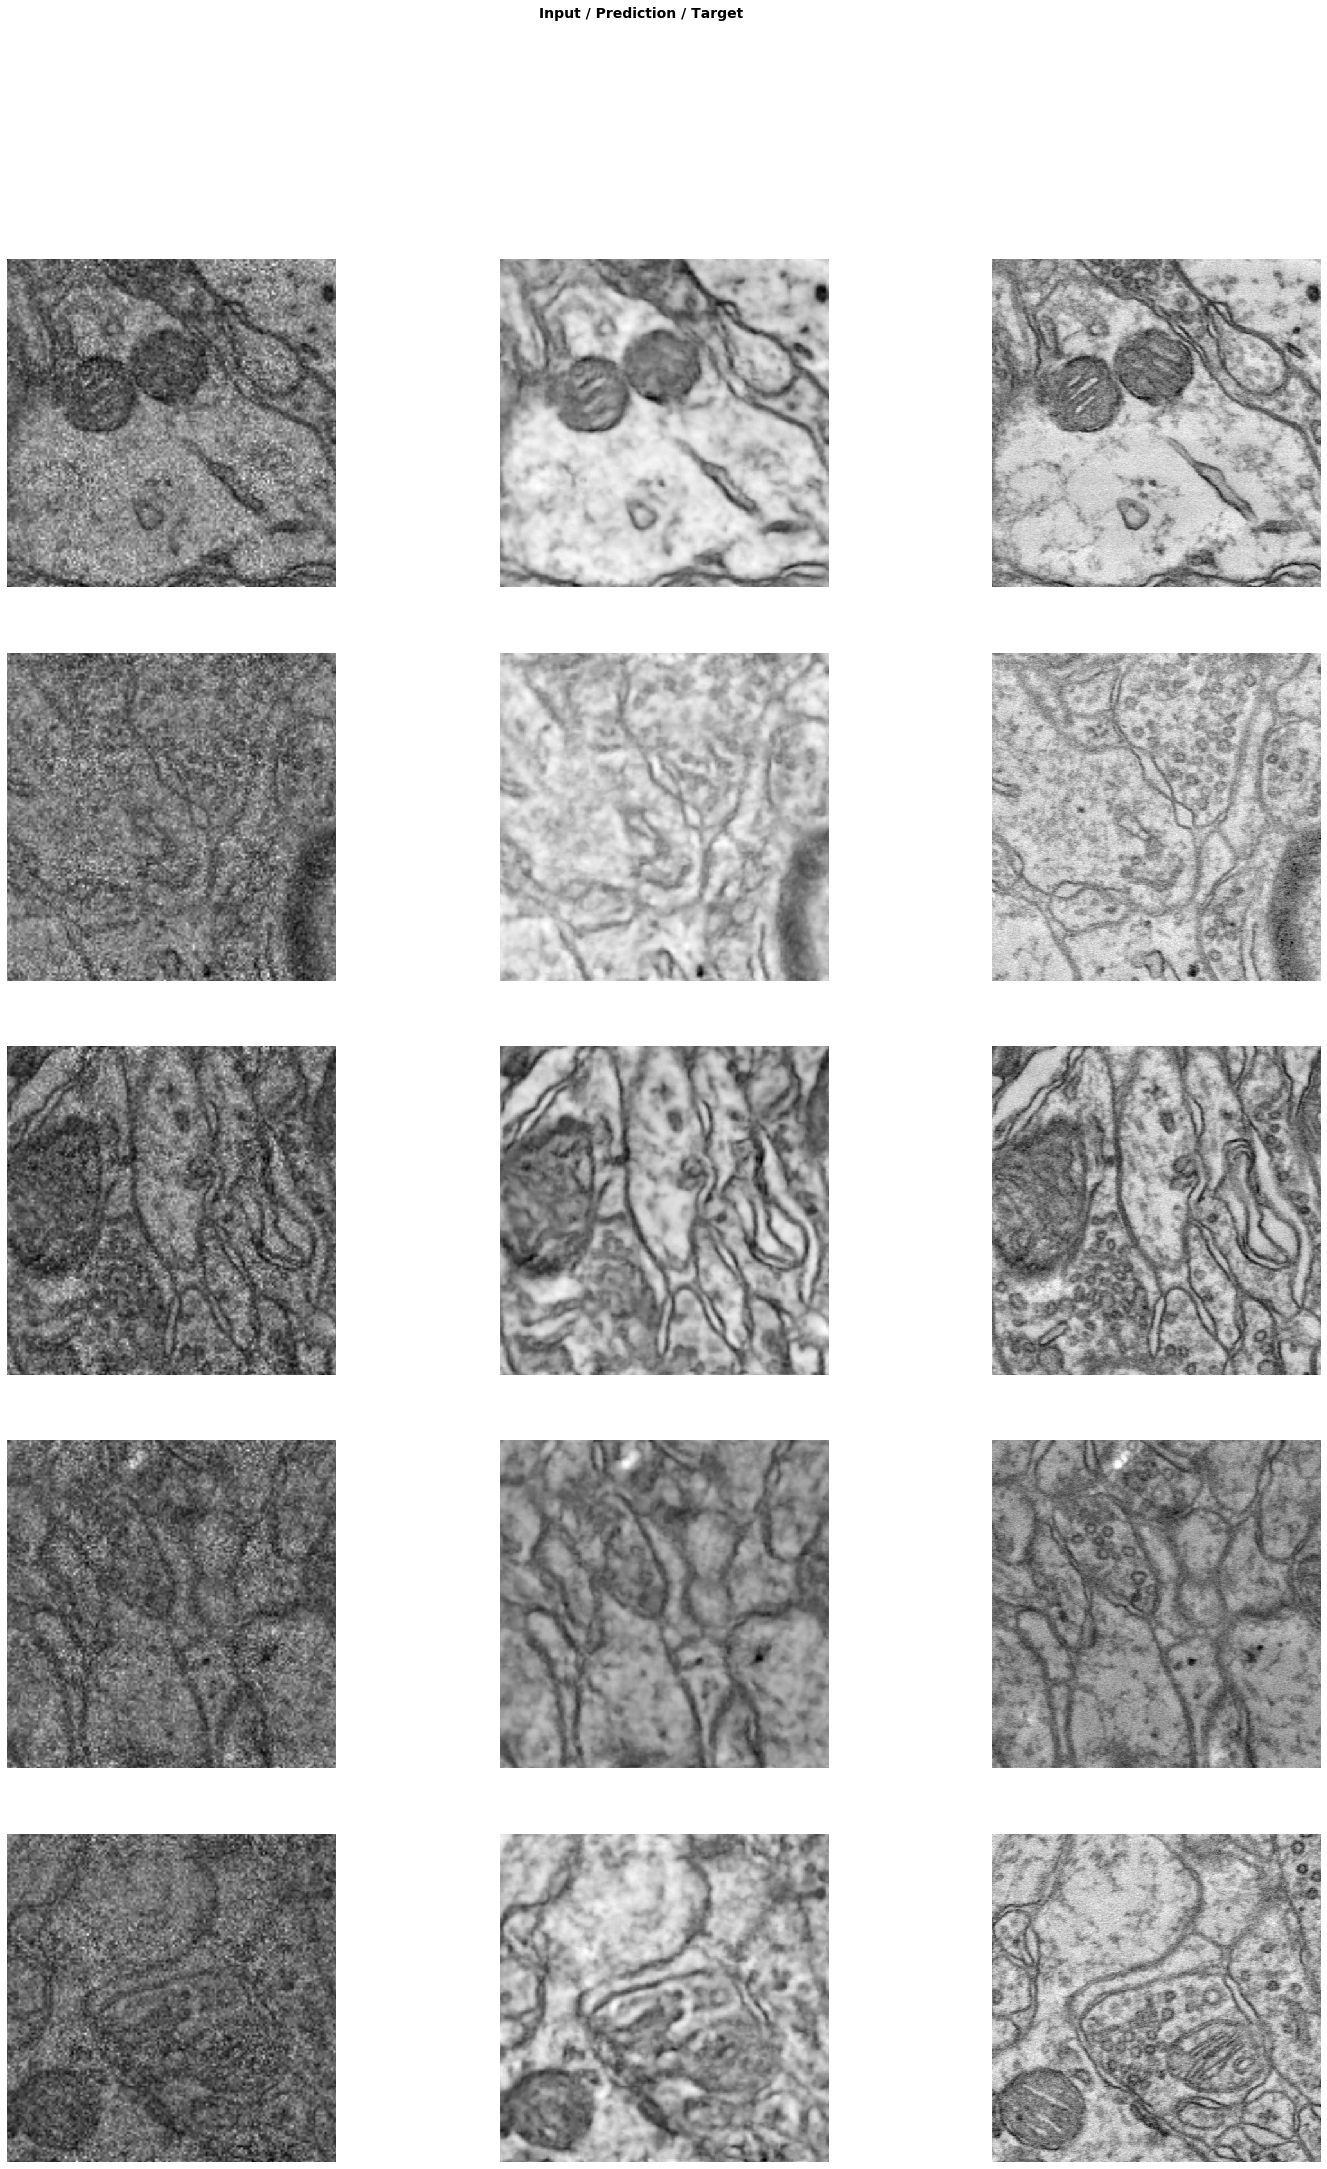

In [35]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)

### 3b

In [36]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


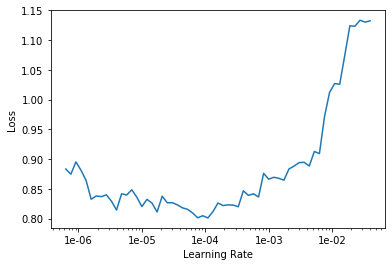

In [37]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = slice(3e-5, 3e-4)
learn.fit_one_cycle(3, max_lr=lr)
learn.save(f'{nb_name}.3b', with_opt=False)

In [ ]:
learn.show_results(rows=5, figsize=(25,35), cmap=plt.cm.gray)